<a href="https://colab.research.google.com/github/Hrithik2212/CNN-Cat-And-Dog-Classification-with-PyTorch-/blob/main/00_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dog and Cat Image Classification with PyTorch

![image info](DCC.jpg)

In [1]:
# imports
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
from PIL import Image
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv 
from glob import glob
import torchsummary
import numpy as np, pandas as pd , matplotlib.pyplot as plt
import seaborn as sns 
from torch.utils.data import Dataset , DataLoader
from torchvision.datasets import ImageFolder
from torch.nn.modules.pooling import MaxPool2d
from pathlib import Path
import random
from PIL import Image 

In [2]:
!nvidia-smi 

Tue Aug 23 17:12:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data Wrangling

In [ ]:
! pip install kaggle

In [3]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d tongpython/cat-and-dog
!unzip cat-and-dog.zip

## Data Exploration and Preparation 

In [3]:
import os 
def walk_through_dir(dir_path):
  for dirpath , dirnames , filenames in os.walk(dir_path):
    print(f'There are {len(dirnames)} directories and {len(filenames)} files in {dirpath}')
walk_through_dir('training_set')
walk_through_dir('test_set')

There are 1 directories and 0 files in training_set
There are 2 directories and 0 files in training_set/training_set
There are 0 directories and 4006 files in training_set/training_set/dogs
There are 0 directories and 4001 files in training_set/training_set/cats
There are 1 directories and 0 files in test_set
There are 2 directories and 0 files in test_set/test_set
There are 0 directories and 1013 files in test_set/test_set/dogs
There are 0 directories and 1012 files in test_set/test_set/cats


Random Image Path training_set/training_set/dogs/dog.164.jpg
Image Class dogs
Image Height 294
Imahe Width  233


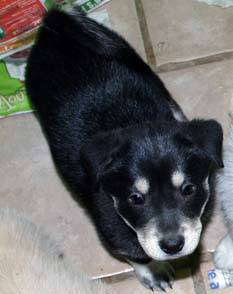

In [4]:
img_path = Path('training_set/training_set')
image_path_list = list(img_path.glob('*/*.jpg'))
rand_img_path = random.choice(image_path_list)

image_class = rand_img_path.parent.stem

img = Image.open(rand_img_path)

print(f'Random Image Path {rand_img_path}')
print(f'Image Class {image_class}')
print(f'Image Height {img.height}')
print(f'Imahe Width  {img.width}' )
img

In [5]:
# device agnostic code 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.ToTensor()
])
data_transform

Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
    RandomHorizontalFlip(p=0.4)
    ToTensor()
)

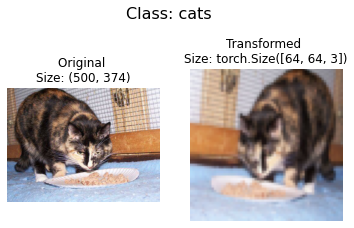

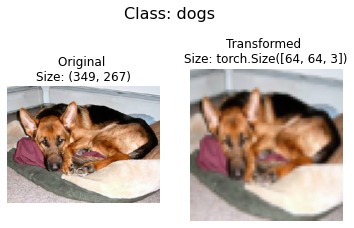

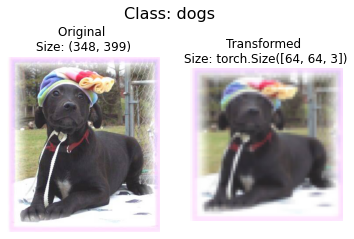

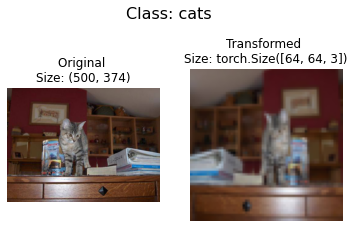

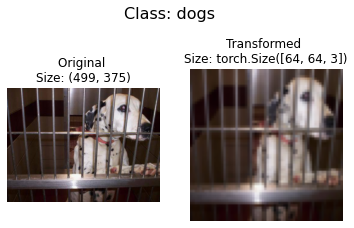

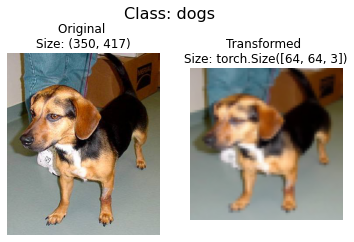

In [7]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=6)

In [8]:
train_dir = 'training_set/training_set'
test_dir = 'test_set/test_set'
class cat_dogs_ds(Dataset):
    def __init__(self,folder):
        cats = glob(folder+'/cats/*.jpg')
        dogs = glob(folder+'/dogs/*.jpg')
        self.fpaths = cats + dogs 
        from random import shuffle, seed; seed(10);
        shuffle(self.fpaths)
        self.target = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths] # dog = 1 , cat = 0 
    
    def __len__(self):
        return len(self.fpaths)

    def __getitem__(self , ix ):
        fp = self.fpaths[ix]
        target = self.target[ix]
        im = cv.imread(fp)[:,:,::-1]
        im = cv.resize(im , (224,224))
        return torch.tensor(im/255).permute(2,0,1).to(device).float(),torch.tensor([target]).float().to(device)

 0 : Cat
 1 : Dog
tensor([0.], device='cuda:0')


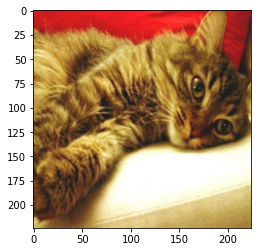

In [9]:
data = cat_dogs_ds(train_dir)
im , label = data[112]
plt.imshow(im.permute(1,2,0).cpu())
print (f' 0 : Cat\n 1 : Dog')
print(label)

In [10]:
test_data = cat_dogs_ds(test_dir)

## Model Building 

In [11]:
def conv_layer(ni,no,kernel_size,stride=1):
    return nn.Sequential(
                    nn.Conv2d(ni,no,kernel_size=kernel_size,stride=stride),
                    nn.ReLU(),
                    nn.BatchNorm2d(no),
                    nn.MaxPool2d(2)
                )

In [12]:
def get_model():
    model = nn.Sequential(
        conv_layer(3,64,3),
        conv_layer(64,512,3),
        conv_layer(512,512,3),
        conv_layer(512,512,3),
        conv_layer(512,512,3),
        nn.Flatten(),
        nn.Linear(12800,1),
        nn.Sigmoid()
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
    loss_fn = nn.BCELoss()
    return model , optimizer , loss_fn

In [13]:
Model_0 , optimizer , loss_fn = get_model()

In [14]:
torchsummary.summary(Model_0,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 222, 222]           1,792
              ReLU-2         [-1, 64, 222, 222]               0
       BatchNorm2d-3         [-1, 64, 222, 222]             128
         MaxPool2d-4         [-1, 64, 111, 111]               0
            Conv2d-5        [-1, 512, 109, 109]         295,424
              ReLU-6        [-1, 512, 109, 109]               0
       BatchNorm2d-7        [-1, 512, 109, 109]           1,024
         MaxPool2d-8          [-1, 512, 54, 54]               0
            Conv2d-9          [-1, 512, 52, 52]       2,359,808
             ReLU-10          [-1, 512, 52, 52]               0
      BatchNorm2d-11          [-1, 512, 52, 52]           1,024
        MaxPool2d-12          [-1, 512, 26, 26]               0
           Conv2d-13          [-1, 512, 24, 24]       2,359,808
             ReLU-14          [-1, 512,

In [15]:
def get_data():
    train = cat_dogs_ds(train_dir)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last = True)
    val = cat_dogs_ds(test_dir)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)
    return trn_dl, val_dl

train_dl , val_dl = get_data()

In [16]:
# Train Function 

def train_batch(x,y,model,opt,loss_fn):
    model.train()
    y_preds = model(x)
    batch_loss = loss_fn(y_preds , y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

# Accuracy function 
@torch.no_grad()
def accuracy(x, y, model):
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [17]:
@torch.no_grad()
def val_loss(x, y, model):
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()  

## Model Training

In [18]:
EPOCHS= 10
train_losses , train_accuricies = [] , []
val_losses , val_accuracies = [] , []
for epoch in range(EPOCHS):
    print(f'EPOCH {epoch+1}')
    train_epoch_losses , train_epoch_accuracies = [] , []
    val_epoch_accuracies = [] 
    for ix , batch in enumerate(iter(train_dl)):
        x  ,y = batch
        batch_loss = train_batch(x,y,Model_0,optimizer,loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.mean(train_epoch_losses)

    for ix ,batch in enumerate(iter(train_dl)):
        x , y = batch
        is_correct = accuracy(x , y, Model_0)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix , batch in enumerate(iter(val_dl)):
        x , y = batch 
        val_is_crt = accuracy(x,y,Model_0)
        val_epoch_accuracies.extend(val_is_crt)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    print(f'Train Loss {train_epoch_loss:.4f} | Train Accuracy {train_epoch_accuracy:.2f} | Val Accuracy {val_epoch_accuracy:.2f}')
    print(f'Done============================================================')
    train_losses.append(train_epoch_loss)
    train_accuricies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

EPOCH 1
Train Loss 0.8816 | Train Accuracy 0.64 | Val Accuracy 0.63
Done============================================================
EPOCH 2
Train Loss 0.7824 | Train Accuracy 0.68 | Val Accuracy 0.67
Done============================================================
EPOCH 3
Train Loss 0.6771 | Train Accuracy 0.78 | Val Accuracy 0.74
Done============================================================
EPOCH 4
Train Loss 0.5254 | Train Accuracy 0.81 | Val Accuracy 0.78
Done============================================================
EPOCH 5
Train Loss 0.4712 | Train Accuracy 0.82 | Val Accuracy 0.78
Done============================================================
EPOCH 6
Train Loss 0.4216 | Train Accuracy 0.87 | Val Accuracy 0.81
Done============================================================
EPOCH 7
Train Loss 0.3146 | Train Accuracy 0.88 | Val Accuracy 0.79
Done============================================================
EPOCH 8
Train Loss 0.2589 | Train Accuracy 0.93 | Val Accuracy 0.83
D

## Model Performance Visuaization over epochs on train and test set 

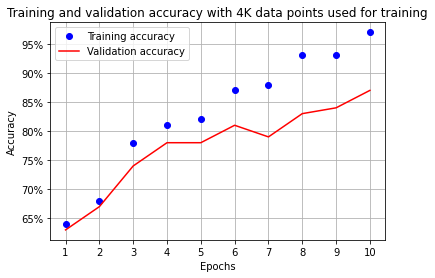

In [23]:
epochs = np.arange(10)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
plt.plot(epochs, train_accuricies, 'bo',label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r',label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with 4K data points used for training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()